This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a pair of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every 'x' BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [1]:
# If haven't downloaded it yet, please get the data file with wget
#!python -m wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt ./data/

#I AM ON WINDOWS SO I HAVE TO DOWNLOAD THE FILE MANUALLY

#ORBIT IS HOURS, BX MINTES AND TDC MEAS. BUT THE ANALOGY ENDS HERE BECAUSE OF DIFFERENT PROPORSION.
#BX COUNTER IS 25 NS, WHEN BX COUNTER REACHES ITS MAXIMUM, ORBIT COUTER IS INCREASED BY ONE AND BX RETURNS TO ZERO (YOU HAVE TO FIND THIS MAXIMUM VALUE OF BX).
#TDC IS 25 OUT OF 30 NANOSECONDS

1\. Create a Pandas DataFrame reading N rows of the `data/data_000637.txt` dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k (check the documentation).

In [2]:
import pandas as pd
import numpy as np
from IPython.display import display

N_rows =None
df = pd.read_csv("./data/data_000637.txt",nrows = N_rows) #read nrows from data file
display(df)

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
1310715,1,0,62,3869211171,762,14
1310716,1,1,4,3869211171,763,11
1310717,1,0,64,3869211171,764,0
1310718,1,0,139,3869211171,769,0


2\. Estimate the number of BX in a ORBIT (the value 'x').

In [3]:
#let's find the maximum value of BX
BX_column = df["BX_COUNTER"]
max_BX = BX_column.max()

print("There are", max_BX +1, "BX in a ORBIT")

There are 3564 BX in a ORBIT


3\. Find out the duration of the data taking in hours, minutes and seconds. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading the whole dataset.

In [4]:
import datetime

nrow=0
row_initial = df.iloc[nrow]
nanoseconds_initial = row_initial['TDC_MEAS']*25/30 + row_initial['BX_COUNTER']*25 + row_initial['ORBIT_CNT']*(max_BX+1)*25

seconds_initial = nanoseconds_initial*10**-9

print(row_initial)
print("\nDuration represented by row number",nrow,":")
print(str(datetime.timedelta(seconds=seconds_initial)))


HEAD                    1
FPGA                    0
TDC_CHANNEL           123
ORBIT_CNT      3869200167
BX_COUNTER           2374
TDC_MEAS               26
Name: 0, dtype: int64

Duration represented by row number 0 :
3 days, 23:45:45.734939


4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information) since the beginning of the data acquisition.

In [5]:
#add a new column to the dataframe and calculate nanoseconds passed from current time to initial time for each row 

df['NS_SINCE_BEGINNING'] = (df['TDC_MEAS']*25/30 + df['BX_COUNTER']*25 + df['ORBIT_CNT']*(max_BX+1)*25) - nanoseconds_initial

display(df)


,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,NS_SINCE_BEGINNING
0,1,0,123,3869200167,2374,26,0.000000e+00
1,1,0,124,3869200167,2374,27,8.125000e-01
2,1,0,63,3869200167,2553,28,4.476625e+03
3,1,0,64,3869200167,2558,19,4.594125e+03
4,1,0,64,3869200167,2760,25,9.649125e+03
...,...,...,...,...,...,...,...
1310715,1,0,62,3869211171,762,14,9.804161e+08
1310716,1,1,4,3869211171,763,11,9.804161e+08
1310717,1,0,64,3869211171,764,0,9.804161e+08
1310718,1,0,139,3869211171,769,0,9.804163e+08


5\. Use the `.groupby()` method to find out the noisy channels, i.e. the TDC channels with most counts (print to screen the top 3 and the corresponding counts)

In [7]:
#"noisy" channels are the channels with most hits in the dataframe (the maximum sum of 'HEAD' values)
res_groupby = df.groupby('TDC_CHANNEL').sum()
display(res_groupby)

res_sort = res_groupby.sort_values(by=['HEAD'],ascending=False)
display(res_sort)

res_limit3rows = res_sort.iloc[:3]
display(res_limit3rows)


,HEAD,FPGA,ORBIT_CNT,BX_COUNTER,TDC_MEAS,NS_SINCE_BEGINNING
TDC_CHANNEL,,,,,,
1,29653,28438,114733571761779,52999263,430533,1.596715e+13
2,34271,32669,132601566229845,61017792,499099,1.847051e+13
3,23463,21970,90783184937635,41678301,340104,1.260011e+13
4,28755,26403,111259024921199,51473537,416945,1.551359e+13
5,16435,15003,63590404218625,29099531,238778,8.862884e+12
...,...,...,...,...,...,...
129,37,35,143160633554,67804,612,2.025861e+10
130,71,38,274713643273,124418,993,3.843806e+10
137,68,36,263106045511,123920,748,3.868227e+10


,HEAD,FPGA,ORBIT_CNT,BX_COUNTER,TDC_MEAS,NS_SINCE_BEGINNING
TDC_CHANNEL,,,,,,
139,108059,32442,418102549486957,192477704,0,5.779232e+13
64,66020,1439,255444994368975,117767051,962195,3.558054e+13
63,64642,918,250113227630194,115482430,938192,3.478681e+13
61,49479,780,191444453676040,88234674,719044,2.660569e+13
62,49349,1074,190941456938357,87956183,719092,2.654190e+13
...,...,...,...,...,...,...
126,606,606,2344738950466,1062095,8881,3.251400e+11
130,71,38,274713643273,124418,993,3.843806e+10
138,70,36,270844458243,128317,456,3.978692e+10


,HEAD,FPGA,ORBIT_CNT,BX_COUNTER,TDC_MEAS,NS_SINCE_BEGINNING
TDC_CHANNEL,,,,,,
139,108059,32442,418102549486957,192477704,0,5.779232e+13
64,66020,1439,255444994368975,117767051,962195,3.558054e+13
63,64642,918,250113227630194,115482430,938192,3.478681e+13


6\. Count the number of non-empty orbits (i.e. the number of orbits with at least one hit). Count also the number of unique orbits with at least one measurement from TDC_CHANNEL=139.

In [8]:

res_df = df.groupby('ORBIT_CNT').size().reset_index(name='counts')
print("number of non-empty orbits",len(res_df))
display(res_df)


res_df = df[df['TDC_CHANNEL']==139].groupby('ORBIT_CNT').size().reset_index(name='counts')
print("\nnumber of unique orbits with at least one measurement from TDC_CHANNEL=139:",len(res_df))
display(res_df)

number of non-empty orbits 11001


,ORBIT_CNT,counts
0,3869200167,43
1,3869200168,85
2,3869200169,127
3,3869200170,98
4,3869200171,109
...,...,...
10996,3869211167,208
10997,3869211168,109
10998,3869211169,191
10999,3869211170,137



number of unique orbits with at least one measurement from TDC_CHANNEL=139: 10976


,ORBIT_CNT,counts
0,3869200167,4
1,3869200168,8
2,3869200169,11
3,3869200170,9
4,3869200171,9
...,...,...
10971,3869211167,19
10972,3869211168,8
10973,3869211169,13
10974,3869211170,12


7\. **Optional:** Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

,TDC_CHANNEL,counts
0,1,29653
1,2,34271
2,3,23463
3,4,28755
4,5,16435
...,...,...
128,129,37
129,130,71
130,137,68
131,138,70


<AxesSubplot:xlabel='TDC_CHANNEL'>

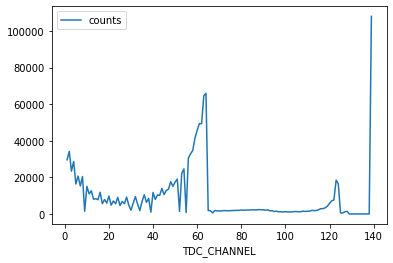

In [9]:
res_df = df.groupby('TDC_CHANNEL').size().reset_index(name='counts')
display(res_df)

res_df.plot(x='TDC_CHANNEL',y='counts')